<h1>ANALIZA FORBESOVE LESTVICE MILJARDERJEV</h1>

In [1]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import seaborn as sns
pd.options.display.max_rows = 8

%matplotlib notebook
%matplotlib inline

Forbesova lestvica je mednarodno uveljavljena lestvica podjetij in posameznikov, ki se določi glede na njihovo finančno stanje in bogastvo. Je seznam najbogatejših ljudi na svetu, ki ga letno objavlja revija Forbes. Vsebuje zgolj osebe, katerih premoženje znaša 1 milijardo ali več.

V projektni nalogi bom analizirala Forbesovo lestvico. Podatke sem črpala s strani [Forbes](https://www.forbes.com/billionaires/), kjer lahko najdemo lestvico 2600 najbogatejših. Za potrebe boljše analiza pa sem pridobila še podatke podatke o številu prebivalcev in BDP per capita vseh držav sveta. Slednji so bili pridobljeni s strani [World Population Review](https://worldpopulationreview.com/country-rankings/gdp-per-capita-by-country). Vsi podatki so bili zbrani oktobra 2022. 

Za vsako osebo z lestvice sem pridobila podatke o imenu, networthu, starosti, nacionalnosti, viru dohodka ter industiji vira dohodka. Relavantni so bili vsi podatki, razen imen oseb, saj jih v ananlizi nisem nikjer uporabila. Za vsako državo sveta pa sem zajela podatke o številu prebivalcev ter BDP per capita. Zbrani tabeli sta naslednji:

Tabela Forbesove lestvice:

In [11]:
forbes = pd.read_csv(os.path.join('Obdelani-podatki/forbes.csv'))
# popravljavnje nekaterih vrednosti:
forbes['name'] = forbes.name.str.replace('&amp;', '&')
forbes['industry'] = forbes.industry.str.replace('&amp;', '&')
forbes['age'] = forbes['age'].astype('Int64')
forbes['networth'] = forbes['networth'].str.replace(r'$', '', regex=True).str.replace(r' B', '', regex=True).astype('float')
forbes

,name,networth,age,country,source,industry
0,Elon Musk,219.0,50,United States,"Tesla, SpaceX",Automotive
1,Jeff Bezos,171.0,58,United States,Amazon,Technology
2,Bernard Arnault & family,158.0,73,France,LVMH,Fashion & Retail
3,Bill Gates,129.0,66,United States,Microsoft,Technology
...,...,...,...,...,...,...
2596,Nari Genomal,1.0,82,Cyprus,apparel,Fashion & Retail
2597,Ramesh Genomal,1.0,71,Cyprus,apparel,Fashion & Retail
2598,Sunder Genomal,1.0,68,United Kingdom,garments,Fashion & Retail
2599,Horst-Otto Gerberding,1.0,69,Germany,flavors and fragrances,Food & Beverage


Tabela s podatki držav sveta:

In [3]:
drzave = pd.read_csv(os.path.join('Obdelani-podatki/worldpopulation.csv'))
# dodajanje podatkov in popravljenje imen držav:
drzave.loc[len(drzave.index)] = [47606,'St. Kitts and Nevis',18082.61]
drzave.loc[len(drzave.index)] = [36686,'Monaco',234315.46]
drzave.loc[len(drzave.index)] = [39039,'Liechtenstein',157754.95]
drzave.loc[len(drzave.index)] = [62792,'Guernsey',52300]
drzave['country'] = drzave['country'].replace({'Eswatini' :'Eswatini (Swaziland)',
                                               'Czech Republic' : 'Czechia'})
drzave

,population,country,gdp_pc
0,647599.0,Luxembourg,118001.00
1,5975689.0,Singapore,97057.00
2,5023109.0,Ireland,94392.00
3,2695122.0,Qatar,93508.00
...,...,...,...
185,47606.0,St. Kitts and Nevis,18082.61
186,36686.0,Monaco,234315.46
187,39039.0,Liechtenstein,157754.95
188,62792.0,Guernsey,52300.00


V projektni nalogi sem želela raziskati predvsem katere države iztopajo po številu milijarderjev, v kateri starostni skupini, industriji in podjetju je največ milijarderjev ter povezanost omenjenih spremenljivk.

<h3>PRIMERJAVA PREMOŽENJA</h3>

Za začetek si poglejmo kako so osebe Forbesove lestvice 'razporejene' po premoženju. 

<AxesSubplot: title={'center': 'Razkorak med milijonarji'}, xlabel='Osebe', ylabel='Networth [v milijardah]'>

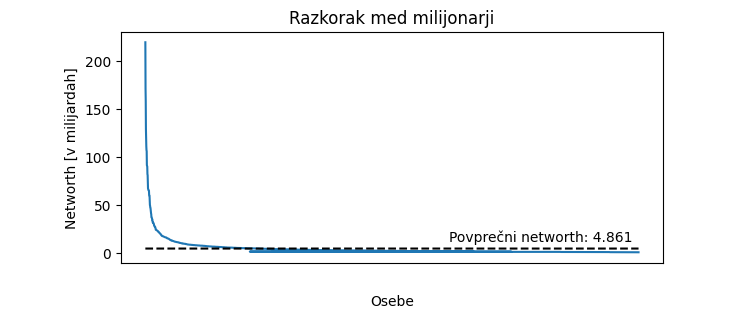

In [27]:
plt.rcParams['figure.figsize'] = [7,3]
y_mean = [forbes.networth.mean()] * len(forbes.networth) # 4.8607499999999995
fig, forbes_plot = plt.subplots()
forbes_plot.plot(forbes.name, forbes.networth, marker = '')
forbes_plot.plot(forbes.name, y_mean, linestyle = '--', color = 'black')
forbes_plot.tick_params(axis='x', colors='white')
forbes_plot.set_title('Razkorak med milijonarji')
plt.text(1600, 12, 'Povprečni networth: {:.3f}'.format(y_mean[0]), color = 'black')
plt.xlabel('Osebe')
plt.ylabel('Networth [v milijardah]')
forbes_plot

Z grafa je razvidno, da je razkorak med milijarderji zelo velik. Tisih, ki imajo več kot okrog 10 milijard je veliko manj kot ostalih. Povprečno premoženje oseb lestvice znaša 4.861 milijarde.

<h3>STAROSTNA STRUKTURA</h3>

Text(0.5, 0, 'Starost')

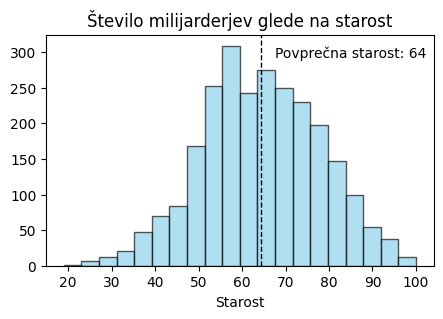

In [327]:
plt.rcParams['figure.figsize'] = [5,3]
forbes_age = forbes.age.dropna()
plot_starost = plt.hist(forbes_age, bins=20, color='skyblue', edgecolor='k', alpha=0.65)
plt.axvline(forbes_age.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(forbes_age.mean()*1.05, max_ylim * 0.9, 'Povprečna starost: {:.0f}'.format(forbes_age.mean()))
plt.rcParams["figure.figsize"] = (6,4)
plt.title('Število milijarderjev glede na starost')
plt.xlabel('Starost')

S histograma razberemo, da je večina milijarderjev skoncentrirana v starostni skupini med 50 in 75 leti. Povprečna starost je 64 let.

<h3>NACIONALNOST</h3>

Odločila sem se, da pogledam katera nacionalnost je po številu najbolj izstopajča. Najprej si poglejmo naslednjo tabelo, ki nam pove koliko milijarderjev je v posamezni državi:

In [31]:
forbes.groupby("country").size().reset_index(name = "število milijarderjev").sort_values(by = "število milijarderjev", ascending = False)

,country,število milijarderjev
70,United States,719
11,China,515
28,India,161
22,Germany,130
...,...,...
17,Estonia,1
6,Belize,1
4,Barbados,1
74,Zimbabwe,1


Največ milijarderjev je torej v ZDA, sledita pa ji Kitajska in Indija. Te številke nam res povedo, v kateri državi je največ najbogatejših, vendar je bolj smiselno, da gledamo število milijarderjev glede na število prebivalcev države ali pa morda glede na BDP države. Slednje sem tudi naredila in prikazala z različnimi grafičnimi prikazi. 

Najprej si poglejmo število milijarderjev glede na število prebivalcev posamezne države.

Priprava in združevanje podatkov držav:

In [4]:
forbes['country_n'] = forbes['country'].replace({'Eswatini (Swaziland)' :'eSwatini',
                                                                   'Guernsey' : 'United Kingdom',
                                                                   'Hong Kong' : 'China',
                                                                   'Monaco' : 'France',
                                                                   'Singapore' : 'Malaysia',
                                                                   'St. Kitts and Nevis' : 'United Kingdom',
                                                                   'United States' : 'United States of America',
                                                                   'Barbados' : 'United Kingdom'})
drzave['country_n'] = drzave['country'].replace({'Eswatini' :'eSwatini',
                                               'Guernsey' : 'United Kingdom',
                                               'Hong Kong' : 'China',
                                               'Monaco' : 'France',
                                               'Singapore' : 'Malaysia',
                                               'St. Kitts and Nevis' : 'United Kingdom',
                                               'United States' : 'United States of America',
                                               'Barbados' : 'United Kingdom'})
forbes_countries = forbes.groupby("country_n").size().reset_index(name = "forbes_count")
forbes_countries = pd.merge(forbes_countries, drzave, how='left', on='country_n')
forbes_countries['forbes_na_preb'] = forbes_countries['forbes_count'] / forbes_countries['population']

Odločila sem se, da rezultate prikažem na zemljevidu, vendar mi ta prikaz ni najbolj realen, saj že vgrajen zemljevid sveta ne vsebuje vseh držav in sicer ravno držav, ki so v tej analizi najbolj relavantne. Vsebuje ne npr. Monaca, Singapurja, Hong Konga ter nekaterih članic Skupnosti narodov (The Commonwealth), ki vemo, da so dom zelo vplivnih in premožnih oseb. Slednje države sem zato pripisala najbolj smiselnim državam, npr. Monaco Franciji, članice Skupnosti narodov Veliki Britaniji, Hong Kong Kitajski, Singapur pa Maleziji.

Za prikaz podatkov sem uporabila knjižnico Folium, ki omogoča enostavno ustvarjanje interaktivnih zemljevidov in vizualizacije geografskih podatkov.

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.rename({'name': 'country_n'}, axis = 1)
world = pd.merge(world, forbes_countries, how='left', on='country_n')

custom_scale = (world['forbes_na_preb'].quantile((0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))).tolist()
map = folium.Map()
zemljevid = folium.Choropleth(
    geo_data = world,
    name = 'choropleth',
    data = world,
    columns = ['country_n', 'forbes_na_preb'],
    key_on = 'feature.properties.country_n',
    threshold_scale = custom_scale,
    fill_color = 'YlGnBu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend = False,
    nan_fill_color = 'white'
    ).add_to(map)
for key in zemljevid._children:
    if key.startswith('color_map'):
        del(zemljevid._children[key])   
zemljevid.add_to(map)
map

<p style="color:deepskyblue;"><b>Tem bolj je država na zemljevidu temne barve, tem več milijarderjev na število prebivalcev ima.</b></p>

Z zemljevida razberemo, da je naveč milijarderjev v Franciji, Veliki Britaniji, Francoski Gvajani, skandinaviji, ZDA, Kanadi ter Avstraliji. Seveda pa to ni nujno res, zaradi prej opisanega problema priključevanje manjših držav večjim. 

Zaradi slednjega problema, sem se odločila, da podatke prikažem še z enostavnim stolpičnim grafom. Spodaj sta dva stolpična grafa; prvi prikazuje število milijarderjev glede na število prebivalcev po državah, drugi pa število milijarderjev glede na BDP posamezne države. 

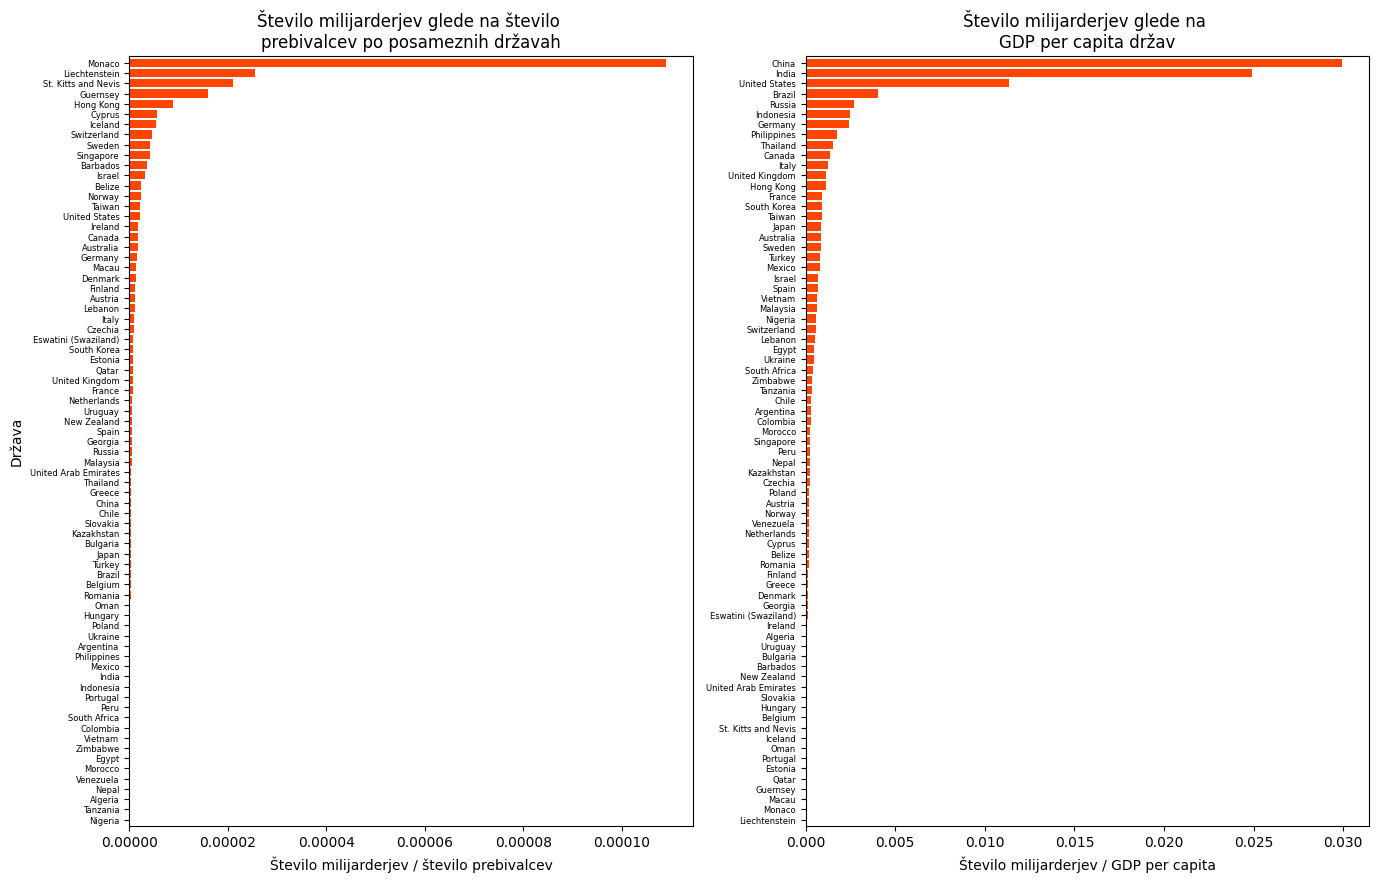

In [334]:
forbes_countries = forbes.groupby("country").size().reset_index(name = "forbes_count")
forbes_countries = pd.merge(forbes_countries, drzave, how='left', on='country')
forbes_countries['forbes_na_preb'] = forbes_countries['forbes_count'] / forbes_countries['population']

forbes_countries_gdp = forbes.groupby("country").size().reset_index(name = "forbes_count")
forbes_countries_gdp = pd.merge(forbes_countries_gdp, drzave, how='left', on='country')
forbes_countries_gdp['forbes_gdppc'] = forbes_countries_gdp['forbes_count'] / forbes_countries_gdp['gdp_pc']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

forbes_countries = forbes_countries.sort_values(by = 'forbes_na_preb', ascending = True).plot.barh(x = 'country', y = 'forbes_na_preb', 
                legend = False, ax = ax1, figsize = (16, 10), width = 0.8, color = 'orangered')
forbes_countries.set_xlabel("Število milijarderjev / število prebivalcev")
forbes_countries.set_ylabel("Država")
forbes_countries.set_title("Število milijarderjev glede na število \nprebivalcev po posameznih državah")

forbes_countries_gdp =forbes_countries_gdp.sort_values(by = 'forbes_gdppc', ascending = True).plot.barh(x = 'country', y = 'forbes_gdppc', 
                legend = False, ax = ax2, figsize = (16, 10), width = 0.8, color = 'orangered')
forbes_countries_gdp.set_xlabel("Število milijarderjev / GDP per capita")
forbes_countries_gdp.set_ylabel(" ")
forbes_countries_gdp.set_title('Število milijarderjev glede na \nGDP per capita držav')

for ax in (ax1, ax2):
    ax.tick_params(axis = 'y', which = 'both', labelsize = 6)

Obravnavajmo prvi prikaz. Po številu milijarderjev glede na število prebivalcev države izstopajo ravno nekatere izmed držav, ki so nam pri zemljevidu predstavljaje težave. V vrhu so Monaco, Lihtenštajn, Sveti Krištof in Nevis, Guernsey in Hong Kong. Torej gre v večini za žepne države. Na zemljevidu sta med drugimi izstopala Francija in Velika Britanija, z zgornjega prikaza pa opazimo, da nista ravno v vrhu lestvice. Na zemljevidu sta izstopali torej zgolj zaradi priključitve drugih, manjših držav.

Na drugem grafu - pri obravnavi števila milijarderjev glede na BDP per capita - so najboljše Kitajska, Indija, ZDA, Brazilija ter Rusija. Če se spomnimo prvotne tabele, ji je ta razvrstitev veliko bolj podobna. Sklepali bi torej lahko, da sta BDP per capita in število milijarderjev povezana, da visok BDP per capita, pomeni višji dohodek prebivalcev, kar vodi v večjo verjetnost, da so med njimi tudi milijarderji. Seveda pa to ni edini dejavnik, ki lahko vpliva na število milijarderjev v državi. Med drugim vpliva tudi tudi fiskalne politika, stabilnost gospodarstva, raven korupcije in videli bomo da tudi število prebivalec. Obstajajo države z visokim BDP per capita, a majhnim številom milijarderjev, in države z nižjim BDP per capita, a večjim številom milijarderjev. Trdimo lahko, da v grobem obstaja povezava med BDP per capita in številom milijarderjev, neposrednega razmerja med njima pa ni.

Poglejmo si povezavo BDP per capita in številom milijarderjev:

Text(0, 0.5, 'Število milijarderjev')

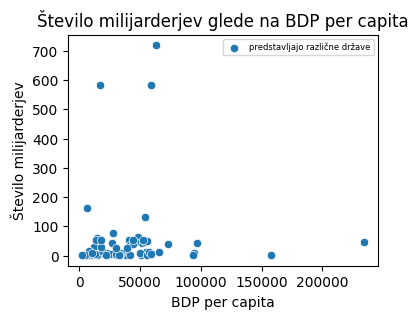

In [47]:
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams.update({'legend.fontsize': 6})
sns.scatterplot(x = forbes_countries.gdp_pc, y = forbes_countries.forbes_count, label = 'predstavljajo različne države', legend = True)
plt.title('Število milijarderjev glede na BDP per capita')
plt.xlabel('BDP per capita')
plt.ylabel('Število milijarderjev')

BDP per capita in število milijarderjev seveda nista v pričakovanem linearnem razmerju. V grafu izstopajo predvsem države z največ milijarderji, iz tabele lahko preberemo, da so to ZDA, Indija in Kitajska, ki pa nimajo največjega BDP per capita. Spodnja desna pika je Monaco, ki ima kar 234315 USD per capita. Po prejšnjem razmišljanju bi moral imeti Monaco značno več kot 700 milijarderjev (če gledamo ZDA), kar je nerealno, saj je njegova pupulacija manj kot 40 tisoč oseb.
Torej povezava med BDP per capita in številom milijarderjev ni razvidna.

Poglejmo si še povezavo med BDP per capita in številom milijarderjev glede na število prebivalcev države:

Text(0, 0.5, 'Število milijarderjev \nna število prebivalcev')

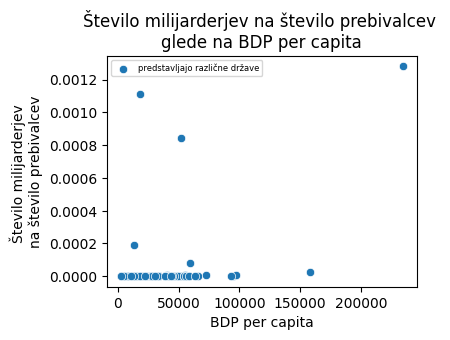

In [50]:
sns.scatterplot(x = forbes_countries.gdp_pc, y = forbes_countries.forbes_na_preb, label = 'predstavljajo različne države', legend = True)
plt.title('Število milijarderjev na število prebivalcev \nglede na BDP per capita')
plt.xlabel('BDP per capita')
plt.ylabel('Število milijarderjev \nna število prebivalcev')

Ponovno pridemo do podobnega sklepa - jasne povezave med številom milijarderjev na število prebivalcev in BDP per capita ni. Morda je slednje povezav bolj občitna če gledamo tudi milijonarje.

<h3>NET WORTH GLEDE NA STAROST</h3>

Text(0, 0.5, 'Networth v milijardah')

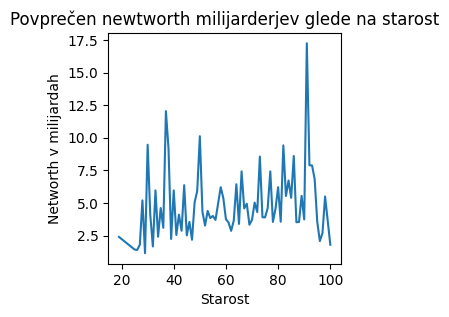

In [335]:
plt.rcParams['figure.figsize'] = [3,3]
forbes_networth_age_plot = forbes.groupby('age')['networth'].mean().plot().set_title('Povprečen newtworth milijarderjev glede na starost')
plt.xlabel('Starost')
plt.ylabel('Networth v milijardah')

<h3>NET WORTH GLEDE PRVIH 30 DRŽAV Z NAJVEČ MILIJARDERJI</h3>

Text(0.5, 1.0, 'Prvih 20 držav, katerih milijarderji imajo v povprečju največ')

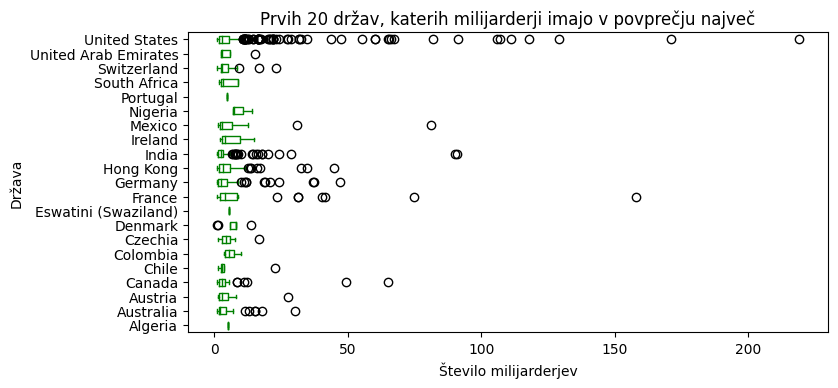

In [357]:
# izberem prvih 16:
plt.rcParams['figure.figsize'] = [8,4]
povprecje = forbes.groupby('country')['networth'].mean().sort_values(ascending = False).reset_index(name = "povprecje")
povprecje = povprecje[['country']].head(21)
forbes_nw = forbes.loc[forbes['country'].isin(povprecje['country'].values.tolist())]

forbes_networth_na_drzavo_plot = forbes_nw.boxplot(by = 'country', column = ['networth'], grid = False, vert=False, color = 'green')
plt.title('')
plt.suptitle('')
forbes_networth_na_drzavo_plot.set_xlabel("Število milijarderjev")
forbes_networth_na_drzavo_plot.set_ylabel("Država")
forbes_networth_na_drzavo_plot.set_title('Prvih 20 držav, katerih milijarderji imajo v povprečju največ')

<h3>INDUSTRIJA</h3>

<AxesSubplot: title={'center': 'Miljarderji glede na industrijo vira prihodka'}>

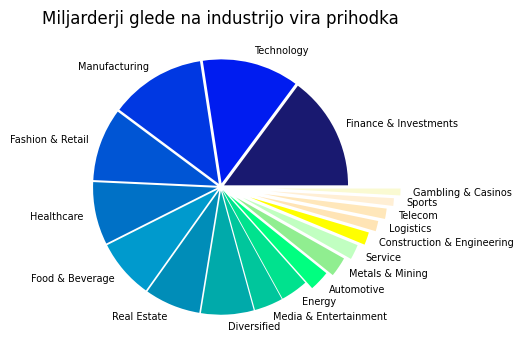

In [347]:
plt.rcParams['figure.figsize'] = [4,5]
colors = ['#191970', '#001CF0','#0038E2', '#0055D4', '#0071C6', '#009ACD', '#008DB8','#00AAAA','#00C69C','#00E28E','#00FF80', '#90EE90','#C1FFC1','#FFFF00', '#FFE4B5', '#FFE7BA', '#FFEFD5', '#FAFAD2']
forbes.groupby('industry').size().sort_values(ascending = False).plot.pie(
    explode = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45),
    colors = colors,
    title = 'Miljarderji glede na industrijo vira prihodka',
    textprops={'fontsize': 7})

<h3>PODJETJA</h3>

<AxesSubplot: title={'center': 'Glavni viri prihodka za več kot 9 milijarderjev'}, xlabel='Glavni vir prihodka', ylabel='Število miljarderjev'>

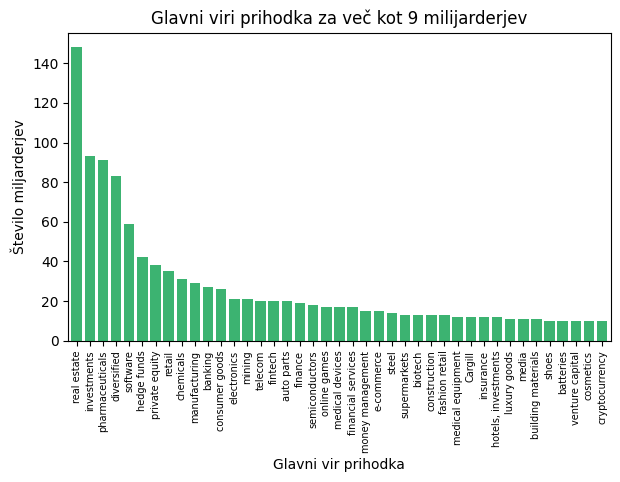

In [351]:
plt.rcParams['figure.figsize'] = [7,4]
forbes_source = forbes.groupby('source').size().sort_values(ascending = False).reset_index(name = "num")
forbes_source_plot = forbes_source[forbes_source.num > 9].plot.bar(x = 'source', y = 'num', legend = False, color = 'mediumseagreen', width = 0.8)
forbes_source_plot.set_xlabel("Glavni vir prihodka")
forbes_source_plot.set_ylabel("Število miljarderjev")
forbes_source_plot.set_title('Glavni viri prihodka za več kot 9 milijarderjev')
forbes_source_plot.set_xticklabels(forbes_source[forbes_source.num > 9].source, rotation = 90, fontsize = 7)
forbes_source_plot

OBRAVNAVA ZA REAL ESTATE:

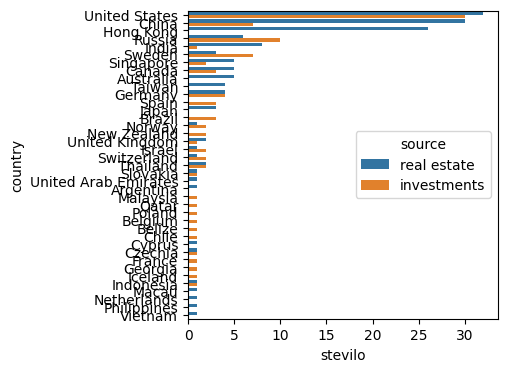

In [260]:
plt.rcParams['figure.figsize'] = [4,4]
forbes_re_i = forbes.loc[forbes['source'].isin(['real estate','investments'])].groupby(['country', 'source']).size().reset_index(name = "stevilo").sort_values(by='stevilo', ascending=False)
forbes_re_i_plot = sns.barplot(data = forbes_re_i, x = 'stevilo', y = 'country', hue = 'source', width = 0.8)
# TO NI OKEJ !!